In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage
from tqdm import tqdm

In [2]:
def cv2_rotate(image, degrees):
    rows, cols = template.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), degrees, 1)
    return cv2.warpAffine(template, M, (cols,rows))

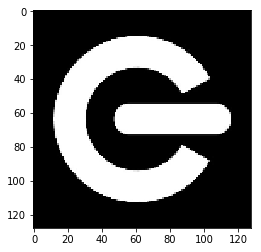

In [3]:
template = cv2.imread('images/on-off.jpg', 0)
template = 255 - template
template = cv2_rotate(template, -90)
template = cv2.resize(template, (128, 128))
plt.imshow(template, cmap='gray')

In [4]:
train_size = 20000
valid_size = 5000
image_size = 32

In [5]:
rotations_degrees = np.random.randint(360, size=(train_size + valid_size))
rotations_radians = rotations_degrees * np.pi / 180

rot_sin_cos = np.empty((train_size + valid_size, 2))
rot_sin_cos[:, 0] = np.sin(rotations_radians)
rot_sin_cos[:, 1] = np.cos(rotations_radians)

In [6]:
X = np.array([cv2.resize(cv2_rotate(template, rotation), (image_size, image_size)) for rotation in tqdm(rotations_degrees)])
X = np.expand_dims(X, 3)

100%|██████████| 25000/25000 [00:02<00:00, 9890.42it/s]


In [7]:
X_train, X_valid = X[:train_size], X[train_size:]
Y_train, Y_valid = rot_sin_cos[:train_size], rot_sin_cos[train_size:]

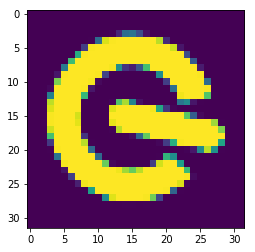

In [8]:
plt.imshow(X_valid[0][:, :, 0])

In [9]:
print(Y_valid[0], rotations_degrees[0], rotations_radians[0])

[-0.22495105  0.97437006] 314 5.480333851262194


In [10]:
from keras import layers
from keras import models

input_layer = layers.Input((image_size, image_size, 1))
x = input_layer

x = layers.Conv2D(32, (5,5), activation='relu')(x)
x = layers.Conv2D(32, (5,5), activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(2)(x)

model = models.Model(input_layer, x)
model.compile(optimizer='adam', loss='cosine_proximity', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
dim is deprecated, use axis instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dens

In [11]:
model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/2
20000/20000 [==============================] - 7s 343us/step - loss: -0.9941 - acc: 0.9859 - val_loss: -0.9999 - val_acc: 0.9988
Epoch 2/2
20000/20000 [==============================] - 5s 264us/step - loss: -0.9997 - acc: 0.9931 - val_loss: -0.9999 - val_acc: 1.0000


In [12]:
Y_predict = model.predict(X_valid)

In [13]:
Y_predict_degrees = np.arctan2(Y_predict[:, 0], Y_predict[:, 1]) * 180 / np.pi

In [15]:
Y_r = np.arctan2(Y_valid[:, 0], Y_valid[:, 1]) * 180 / np.pi

In [14]:
Y_predict_degrees[:50]

array([ -13.273812, -156.38457 ,  156.09004 ,  123.29733 ,  124.65972 ,
        -80.86681 , -169.9115  , -153.33209 ,  104.56914 , -174.94638 ,
       -173.27739 ,  -33.635403,  164.7504  ,  -73.97227 ,  -15.34733 ,
       -118.45711 ,  131.89868 ,  -69.66937 ,   10.91128 , -145.15549 ,
         29.651428,  -41.73596 ,   16.4078  ,   78.707924,  -96.13392 ,
         39.16235 , -112.89662 , -156.38457 , -133.8122  ,  132.7978  ,
         30.786135,   82.62309 ,    5.841584,  103.50792 ,  -12.187311,
        -61.467587,   79.61585 ,  171.42528 , -128.6491  ,  -88.66404 ,
        -89.84561 ,   19.51589 ,  -92.491196,   19.51589 , -114.212006,
       -160.39496 ,   64.04175 ,  -60.343098,  123.29733 , -164.45114 ],
      dtype=float32)

In [17]:
Y_r[:50]

array([ -13., -156.,  155.,  123.,  124.,  -80., -170., -153.,  104.,
       -175., -173.,  -34.,  164.,  -74.,  -15., -118.,  131.,  -70.,
         11., -145.,   29.,  -42.,   16.,   78.,  -96.,   38., -113.,
       -156., -133.,  132.,   30.,   82.,    5.,  103.,  -12.,  -62.,
         79.,  171., -128.,  -88.,  -89.,   19.,  -92.,   19., -114.,
       -160.,   63.,  -61.,  123., -164.])

(array([868., 888., 876., 845., 751., 442., 145., 105.,  54.,  26.]),
 array([7.62939453e-04, 1.63232422e-01, 3.25701904e-01, 4.88171387e-01,
        6.50640869e-01, 8.13110352e-01, 9.75579834e-01, 1.13804932e+00,
        1.30051880e+00, 1.46298828e+00, 1.62545776e+00]),
 <a list of 10 Patch objects>)

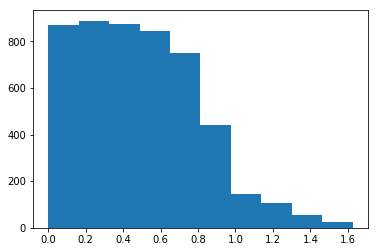

In [16]:
diff = np.abs(Y_predict_degrees - Y_r)
plt.hist(diff)

In [18]:
Y_valid[:10]

array([[-0.22495105,  0.97437006],
       [-0.40673664, -0.91354546],
       [ 0.42261826, -0.90630779],
       [ 0.83867057, -0.54463904],
       [ 0.82903757, -0.5591929 ],
       [-0.98480775,  0.17364818],
       [-0.17364818, -0.98480775],
       [-0.4539905 , -0.89100652],
       [ 0.97029573, -0.2419219 ],
       [-0.08715574, -0.9961947 ]])

In [19]:
Y_predict[:10]

array([[-115.07312 ,  487.78928 ],
       [-281.58487 , -644.04956 ],
       [ 230.84691 , -520.6912  ],
       [ 472.26382 , -310.1878  ],
       [ 465.87692 , -322.10416 ],
       [-547.42053 ,   88.00784 ],
       [-116.169075, -652.9289  ],
       [-311.2639  , -619.74414 ],
       [ 567.85675 , -147.58911 ],
       [ -56.22662 , -635.82    ]], dtype=float32)